In [31]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import joblib
import csv

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [2]:
file_path = '{}/nem-data/nemde_clean/df_clean_interconnectors.pkl'.format(os.environ['HOME'])
df = pd.read_pickle(file_path)

In [3]:
print(df.shape[0] * 0.8)
l = int(df.shape[0] * 0.8)
df.iloc[[l],:]

645719.2000000001


CO2E_EMISSIONS_FACTOR  minute_sin  minute_cos  hour_sin  \
2017-09-28 02:10:00               1.154818    0.866025         0.5       0.5   

                     hour_cos  weekday_sin  weekday_cos  month_sin  \
2017-09-28 02:10:00  0.866025          0.0          1.0       -1.0   

                        month_cos      lag1  ...     lag7      lag8      lag9  \
2017-09-28 02:10:00 -1.836970e-16  1.013138  ...  0.87219  0.841156  1.013504   

                        lag10     lag11     lag12  horizon0  demand  \
2017-09-28 02:10:00  1.013138  1.015004  1.015004  1.154818  1025.8   

                     demand_capacity  interconnector  
2017-09-28 02:10:00         0.386467      -189.34882  

[1 rows x 25 columns]

In [4]:
df_train_val = df[df.index < dt.datetime(2017,5,31,0,0,0)]
df_test_set = df[df.index >= dt.datetime(2017,5,31,0,0,0)]

In [5]:
print(df_train_val.index.max())
print(df_test_set.index.min())

2017-05-30 23:55:00
2017-05-31 00:00:00


### __Splitting test and train__

In [1]:
def train_test_ts(df, relative_train, maximal_lag, horizon):
    '''
    Time series (ts) split function creates a train/test set under consideration of potential overlap between the two due to lag processing
    X_train, y_train, X_test, y_test = ...
    df=must contain target column as "target"; all other columns must be used as features
    percentage_train=how much of the total dataset shall be used for training; must be added between 0 - 1
    maximal_lag=out of all lag feature engineering, enter the maximal lag number
    '''
    k = int(df.shape[0] * relative_train)
    data_train = df.iloc[:k,:]
    #to avoid overlapping of train and test data, a gap of the maximal lag - 1 must be included between the two sets
    data_test = df.iloc[k+maximal_lag:,:]
    
    assert data_train.index.max() < data_test.index.min()
    
    #returns in the sequence X_train, y_train, X_test, y_test
    return (data_train.drop(columns=[f"horizon{horizon}","CO2E_EMISSIONS_FACTOR"], axis=1), data_train[f"horizon{horizon}"],
            data_test.drop(columns=[f"horizon{horizon}","CO2E_EMISSIONS_FACTOR"], axis=1), data_test[f"horizon{horizon}"])

In [10]:
df = df_train_val
relative_train = 0.8
maximal_lag = 12

k = int(df.shape[0] * relative_train)
data_train = df.iloc[:k,:]
#to avoid overlapping of train and test data, a gap of the maximal lag - 1 must be included between the two sets
data_test = df.iloc[k+maximal_lag:,:]

In [7]:
X_train, y_train, X_test, y_test = train_test_ts(df_train_val, 0.8, 12)

In [12]:
print(X_train.columns)
print(X_test.columns)

Index(['minute_sin', 'minute_cos', 'hour_sin', 'hour_cos', 'weekday_sin',
       'weekday_cos', 'month_sin', 'month_cos', 'lag1', 'lag2', 'lag3', 'lag4',
       'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12',
       'demand', 'demand_capacity', 'interconnector'],
      dtype='object')
Index(['minute_sin', 'minute_cos', 'hour_sin', 'hour_cos', 'weekday_sin',
       'weekday_cos', 'month_sin', 'month_cos', 'lag1', 'lag2', 'lag3', 'lag4',
       'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12',
       'demand', 'demand_capacity', 'interconnector'],
      dtype='object')


### __train xgboost__

In [29]:
learning_rate = [0.01, 0.1] #learning_rate
max_depth = [50]
n_estimators = [100]
reg_alpha = [0.05]
reg_lambda = [0]

params = {
    "learning_rate": learning_rate,
    "max_depth": max_depth,
    "n_estimators": n_estimators,
    "reg_alpha": reg_alpha,
    "reg_lambda": reg_lambda,
}

params

{'learning_rate': [0.01, 0.1],
 'max_depth': [50],
 'n_estimators': [100],
 'reg_alpha': [0.05],
 'reg_lambda': [0]}

In [28]:
def XGB_GS_ts(X_train, y_train, params,run, n_splits=2, n_jobs=7, verbose=5):
    '''
    Function performs GridSearch using TimeSeries CV
    X_train, y_train
    n_splits=number of splits in TimeSeriesCV; default:3
    n_jobs=default: -1
    verbose=default:5
    '''
    
    model = xgb.XGBRegressor()

    tscv = TimeSeriesSplit(n_splits=n_splits)
    gsearch = GridSearchCV(estimator=model, cv=tscv,
                            param_grid=params, n_jobs=n_jobs, verbose=verbose)

    gsearch.fit(X_train, y_train)
    
    print("Best params were: {}".format(gsearch.best_params_))
    
    pd.DataFrame(gsearch.cv_results_).to_csv('{}/nem-data/trainings/grid_searches/{}_GS.csv'.format(os.environ['HOME'],run))
    joblib.dump(gsearch, '{}/nem-data/trainings/gridsearches/{}_GS_object.pkl'.format(os.environ['HOME'], run))
    
    best_model = gsearch.best_estimator_
    
    error_test = np.sqrt(mse(y_test, best_model.predict(X_test))/y_test.mean())
    error_train = np.sqrt(mse(y_train, best_model.predict(X_train))/y_train.mean())
    compare_train_test_error = abs(error_test - error_train)
    
    settings = {
    "Model": "XGBoost",
    "Feature Description": "sine_cosine, lag_12, horizon=0, demand, capacity, interconnectors",
    "Model Description": gsearch.best_params_
    }

    print(f"Root mean squared percentage error: {error_train, error_test}")
    log_test_results(
        settings, error_train, error_test,
        compare_train_test_error, run
    )
    
    return gsearch

In [30]:
gsearch = XGB_GS_ts(X_train,y_train,params,4)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   4 | elapsed:  9.6min remaining:  9.6min
[Parallel(n_jobs=7)]: Done   4 out of   4 | elapsed: 19.0min remaining:    0.0s
[Parallel(n_jobs=7)]: Done   4 out of   4 | elapsed: 19.0min finished
/home/bastian/Environment/DSR_portfolio/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/bastian/Environment/DSR_portfolio/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:29:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best params were: {'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 100, 'reg_alpha': 0.05, 'reg_lambda': 0}
Root mean squared percentage error: (0.004771012911918365, 0.35569846008739964)


In [21]:
def log_test_results(settings, error_train, error_test, train_test_error_difference, file_name):
    csv_path = '{}/nem-data/trainings/grid_searches/{}_GS_log.csv'.format(os.environ['HOME'], file_name)
    must_add_headers = False if os.path.isfile(csv_path) else True

    with open(csv_path, mode='a') as test_results:
        writer = csv.writer(test_results,
                            delimiter=',',
                            quotechar='"',
                            quoting=csv.QUOTE_MINIMAL)

        if must_add_headers:
            writer.writerow([
                'Model', 'Feature Description', "Model Description", "Training error", "Test error",
                "Difference_train_test_error"
            ])
        writer.writerow([
            settings["Model"], settings["Feature Description"],
            str(settings["Model Description"]), error_train, error_test,
            train_test_error_difference
        ])

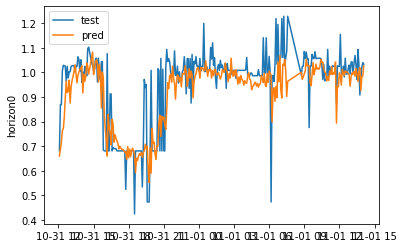

In [93]:
sns.lineplot(y_test.index[:300],y_test.iloc[:300], label="test")
sns.lineplot(y_test.index[:300],pred[:300], label="pred")